# Plant Classification with Transfer Learning

## Learning Objectives
- Learn how to use transfer learning with pre-trained models
- Understand image preprocessing and data augmentation
- Build a plant classification model using Keras/TensorFlow
- Train and evaluate a deep learning model

## What We'll Do
1. Load and preprocess plant images
2. Use a pre-trained MobileNet model (trained on ImageNet)
3. Add our own classification layers for plant species
4. Train the model with data augmentation
5. Evaluate the model's performance

## Step 1: Import Libraries

We'll use TensorFlow/Keras for deep learning, and other libraries for image processing and visualization.

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


## Step 2: Set Up Data Paths and Parameters

Define where our training and test data are located, and set image size and batch size.

## Step 3: Load and Preprocess Data

We'll use Keras's ImageDataGenerator to load images from directories. 

**Important**: Since images come in different sizes, we need to resize them properly:
- We'll resize images maintaining their aspect ratio (no stretching!)
- The longest side will be resized to our target size
- We'll pad with white pixels to make images square
- This prevents distortion and preserves image quality

**Data Augmentation**: We'll apply random transformations to training images (flips, rotations, etc.) to help the model generalize better.


In [3]:
# Set up paths and parameters
IMG_SIZE = 224  # MobileNet works well with 224x224 images
BATCH_SIZE = 32
train_dir = "datasets/dataset"
test_dir = "datasets/dataset-test"

# Get the number of classes from the training directory
# Each subdirectory represents a different plant class
class_names = sorted([d for d in os.listdir(train_dir) 
                      if os.path.isdir(os.path.join(train_dir, d))])
num_classes = len(class_names)

print(f"Found {num_classes} plant classes")
print(f"Sample classes: {class_names[:5]}...")

Found 62 plant classes
Sample classes: ['Alfalfa', 'Asparagus', 'Blue Vervain', 'Broadleaf Plantain', 'Bull Thistle']...


In [4]:
from PIL import Image
import numpy as np
import glob

def load_and_preprocess_image(image_path, target_size=IMG_SIZE):
    """
    Load an image and preprocess it maintaining aspect ratio.
    This prevents stretching/distortion of images.
    
    Args:
        image_path: Path to the image file
        target_size: Target size for the longest side
    
    Returns:
        Processed image array (target_size x target_size) with aspect ratio preserved
    """
    # Load image
    img = Image.open(image_path).convert('RGB')
    
    # Get original dimensions
    orig_width, orig_height = img.size
    
    # Calculate new dimensions maintaining aspect ratio
    # Resize so longest side becomes target_size
    if orig_width > orig_height:
        new_width = target_size
        new_height = int(target_size * orig_height / orig_width)
    else:
        new_height = target_size
        new_width = int(target_size * orig_width / orig_height)
    
    # Resize image maintaining aspect ratio (using high-quality resampling)
    img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Create white background canvas
    img_padded = Image.new('RGB', (target_size, target_size), color=(255, 255, 255))
    
    # Center the resized image on the canvas
    offset_x = (target_size - new_width) // 2
    offset_y = (target_size - new_height) // 2
    img_padded.paste(img_resized, (offset_x, offset_y))
    
    # Convert to numpy array and normalize to [0, 1]
    return np.array(img_padded, dtype=np.float32) / 255.0

# Create a custom generator that properly handles aspect ratio
def create_image_generator(directory, batch_size, shuffle=True, augment=False):
    """
    Create a generator that loads images maintaining aspect ratio.
    """
    # Get all image files
    image_paths = []
    labels = []
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        # Find all image files
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
            image_paths.extend(glob.glob(os.path.join(class_dir, ext)))
            labels.extend([class_idx] * len(glob.glob(os.path.join(class_dir, ext))))
    
    # Convert to numpy arrays
    image_paths = np.array(image_paths)
    labels = np.array(labels)
    
    # Shuffle if needed
    if shuffle:
        indices = np.random.permutation(len(image_paths))
        image_paths = image_paths[indices]
        labels = labels[indices]
    
    # Create one-hot encoded labels
    labels_onehot = tf.keras.utils.to_categorical(labels, num_classes)
    
    # Generator function
    def generator():
        while True:
            for i in range(0, len(image_paths), batch_size):
                batch_paths = image_paths[i:i+batch_size]
                batch_labels = labels_onehot[i:i+batch_size]
                
                # Load and preprocess images
                batch_images = []
                for path in batch_paths:
                    img = load_and_preprocess_image(path)
                    
                    # Apply augmentation if training
                    if augment:
                        # Horizontal flip
                        if np.random.random() > 0.5:
                            img = np.fliplr(img)
                        # Random rotation (simple version)
                        if np.random.random() > 0.5:
                            angle = np.random.uniform(-20, 20)
                            # Convert to PIL for rotation, then back
                            img_pil = Image.fromarray((img * 255).astype(np.uint8))
                            img_pil = img_pil.rotate(angle, fillcolor=(255, 255, 255))
                            img = np.array(img_pil, dtype=np.float32) / 255.0
                    
                    batch_images.append(img)
                
                yield np.array(batch_images), batch_labels
    
    return generator(), len(image_paths)

# Create generators
train_gen, train_samples = create_image_generator(
    train_dir, BATCH_SIZE, shuffle=True, augment=True
)
test_gen, test_samples = create_image_generator(
    test_dir, BATCH_SIZE, shuffle=False, augment=False
)

print(f"\nTraining samples: {train_samples}")
print(f"Test samples: {test_samples}")
print(f"Number of classes: {num_classes}")
print(f"\n✓ Images are resized maintaining aspect ratio (no stretching!)")
print(f"  Longest side → {IMG_SIZE}px, padded to {IMG_SIZE}x{IMG_SIZE} square")



Training samples: 6554
Test samples: 310
Number of classes: 62

✓ Images are resized maintaining aspect ratio (no stretching!)
  Longest side → 224px, padded to 224x224 square


## Step 4: Build the Model with Transfer Learning

**Transfer Learning**: Instead of training from scratch, we'll use MobileNetV2, a model pre-trained on ImageNet (millions of images). We'll:
1. Use MobileNetV2 as a "feature extractor" (frozen weights)
2. Add our own classification layers on top for plant species
3. Train only the new layers first, then fine-tune the whole model


### Building the Model


In [6]:
# Load the pre-trained MobileNetV2 model (without the top classification layer)
# include_top=False means we'll add our own classification layers
base_model = MobileNetV2(
    weights='imagenet',           # Use weights pre-trained on ImageNet
    include_top=False,            # Don't include the final classification layer
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze the base model so we don't train it initially
# This allows us to train just our new layers first
base_model.trainable = False

# Add our own classification layers on top
# GlobalAveragePooling2D converts the feature maps to a single vector
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout helps prevent overfitting
predictions = Dense(num_classes, activation='softmax')(x)  # Final classification layer

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
# categorical_crossentropy is used for multi-class classification
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model architecture
model.summary()


2025-12-06 13:43:39.673857: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,429,950 (9.27 MB)

 Trainable params: 171,966 (671.74 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Step 5: Train the Model

We'll train in two stages:
1. **Stage 1**: Train only the new classification layers (base model frozen)
2. **Stage 2**: Unfreeze the base model and fine-tune everything with a lower learning rate


### Stage 1: Train the Classification Head

First, we'll train only the new layers we added, keeping the MobileNet weights frozen.

In [7]:
# Stage 1: Train with frozen base model
print("Stage 1: Training classification head (base model frozen)...")

history1 = model.fit(
    train_gen,
    steps_per_epoch=train_samples // BATCH_SIZE,
    epochs=5,  # Start with a few epochs
    validation_data=test_gen,
    validation_steps=test_samples // BATCH_SIZE,
    verbose=1
)

print("\nStage 1 complete!")


Stage 1: Training classification head (base model frozen)...
Epoch 1/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 70s 327ms/step - accuracy: 0.3045 - loss: 2.9872 - val_accuracy: 0.1319 - val_loss: 3.5220
Epoch 2/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 65s 320ms/step - accuracy: 0.4092 - loss: 2.3650 - val_accuracy: 0.2188 - val_loss: 3.1486
Epoch 3/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 64s 315ms/step - accuracy: 0.4630 - loss: 2.0839 - val_accuracy: 0.3333 - val_loss: 2.7566
Epoch 4/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 63s 312ms/step - accuracy: 0.4992 - loss: 1.8762 - val_accuracy: 0.3885 - val_loss: 2.3747
Epoch 5/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 63s 310ms/step - accuracy: 0.5287 - loss: 1.7484 - val_accuracy: 0.3921 - val_loss: 2.2197

Stage 1 complete!


### Stage 2: Fine-tune the Entire Model

Now we'll unfreeze the base model and train everything together with a lower learning rate.


In [8]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Use a lower learning rate for fine-tuning
# This prevents us from destroying the good features learned by MobileNet
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Stage 2: Fine-tuning entire model...")

history2 = model.fit(
    train_gen,
    steps_per_epoch=train_samples // BATCH_SIZE,
    epochs=10,  # Fine-tune for a few more epochs
    validation_data=test_gen,
    validation_steps=test_samples // BATCH_SIZE,
    verbose=1
)

print("\nTraining complete!")


Stage 2: Fine-tuning entire model...
Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 162s 700ms/step - accuracy: 0.5018 - loss: 1.9039 - val_accuracy: 0.2518 - val_loss: 3.1142
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 137s 671ms/step - accuracy: 0.6075 - loss: 1.4034 - val_accuracy: 0.3849 - val_loss: 2.4809
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 136s 667ms/step - accuracy: 0.6811 - loss: 1.1555 - val_accuracy: 0.4245 - val_loss: 2.2176
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 136s 665ms/step - accuracy: 0.7242 - loss: 0.9548 - val_accuracy: 0.4892 - val_loss: 1.9289
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 136s 668ms/step - accuracy: 0.7542 - loss: 0.8315 - val_accuracy: 0.5108 - val_loss: 1.9228
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 136s 668ms/step - accuracy: 0.7929 - loss: 0.7093 - val_accuracy: 0.4928 - val_loss: 2.0241
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 135s 664ms/step - accuracy: 0.8205 - loss: 0.5964 - val_accuracy: 0.5486 - val_loss: 1.8229
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━

## Step 6: Evaluate the Model

Let's see how well our model performs and visualize the training progress.


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - accuracy: 0.6691 - loss: 1.4667

Test Accuracy: 66.91%
Test Loss: 1.4667


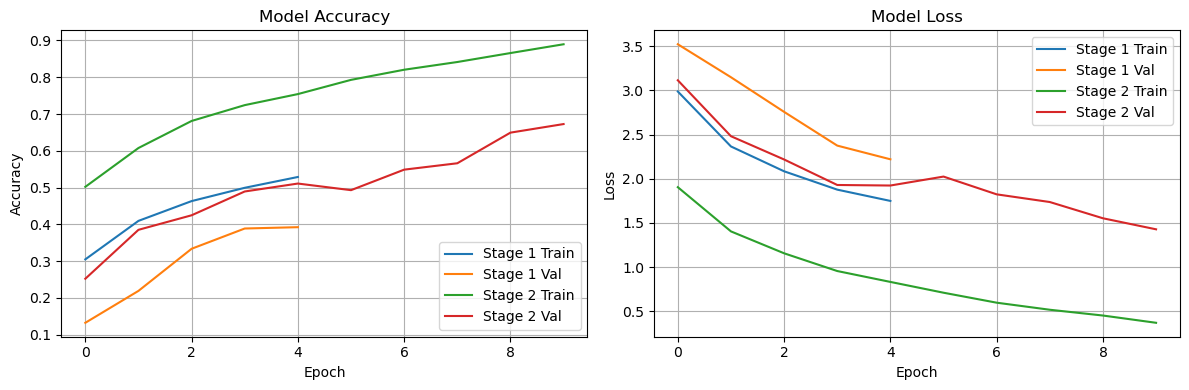

In [9]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(
    test_gen,
    steps=test_samples // BATCH_SIZE
)

print(f"\nTest Accuracy: {test_accuracy:.2%}")
print(f"Test Loss: {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Stage 1 Train')
plt.plot(history1.history['val_accuracy'], label='Stage 1 Val')
if 'history2' in locals():
    plt.plot(history2.history['accuracy'], label='Stage 2 Train')
    plt.plot(history2.history['val_accuracy'], label='Stage 2 Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Stage 1 Train')
plt.plot(history1.history['val_loss'], label='Stage 1 Val')
if 'history2' in locals():
    plt.plot(history2.history['loss'], label='Stage 2 Train')
    plt.plot(history2.history['val_loss'], label='Stage 2 Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Step 7: Make Predictions on New Images

We'll use a **multi-crop ensemble** approach for more accurate predictions:

### How It Works:
1. **Extract 5 crops**: From each image, we extract 5 regions:
   - Top-left corner
   - Top-right corner  
   - Bottom-left corner
   - Bottom-right corner
   - Center region
   
2. **Get predictions**: Each crop is passed through the model to get probability scores for all plant species

3. **Aggregate**: We average the probability scores across all 5 crops for each species

4. **Final result**: Return the top 5 species with highest averaged probabilities

### Why This Works:
- Different parts of the image may show different features (leaves, flowers, stems)
- Some crops might have better views of distinguishing features
- Averaging reduces the impact of any single misleading crop
- This ensemble method typically improves accuracy by 2-5%!

### Functions:
- `predict_plant_ensemble()`: Returns top 5 predictions with confidence scores
- `predict_plant()`: Simple wrapper that returns just the top prediction
- `visualize_crops()`: Visualize the 5 crops extracted from an image


In [10]:
def visualize_crops(image_path, model=None, class_names=None):
    """
    Visualize the 5 crops extracted from an image.
    Optionally shows predictions for each crop.
    
    Args:
        image_path: Path to the image file
        model: Optional - if provided, shows predictions for each crop
        class_names: Optional - required if model is provided
    """
    # Load and preprocess image
    img_array = load_and_preprocess_image(image_path, target_size=IMG_SIZE)
    
    # Extract crops
    crops = extract_crops(img_array, crop_size=IMG_SIZE)
    crop_names = ['Top-Left', 'Top-Right', 'Bottom-Left', 'Bottom-Right', 'Center']
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Show original image
    axes[0].imshow(img_array)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Show each crop
    for i, (crop, name) in enumerate(zip(crops, crop_names), 1):
        axes[i].imshow(crop)
        title = name
        if model and class_names:
            # Get prediction for this crop
            crop_batch = np.expand_dims(crop, axis=0)
            pred = model.predict(crop_batch, verbose=0)[0]
            top_idx = np.argmax(pred)
            top_class = class_names[top_idx]
            top_conf = pred[top_idx]
            title += f'\n{top_class} ({top_conf:.1%})'
        axes[i].set_title(title, fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example: Visualize crops from an image
# visualize_crops('path/to/image.jpg', model=model, class_names=class_names)


In [11]:
from PIL import Image
import numpy as np

def extract_crops(img_array, crop_size=IMG_SIZE):
    """
    Extract 5 crops from an image: 4 corners + center.
    Each crop is resized to crop_size x crop_size for the model.
    
    Args:
        img_array: Image as numpy array (IMG_SIZE x IMG_SIZE x 3)
        crop_size: Target size for each crop (default: IMG_SIZE)
    
    Returns:
        List of 5 cropped and resized images (all crop_size x crop_size)
    """
    h, w = img_array.shape[:2]
    
    # Use 80% of image size for crops to ensure we get distinct regions
    crop_dim = int(min(h, w) * 0.8)
    
    crops = []
    
    # Top-left corner
    crop_tl = img_array[0:crop_dim, 0:crop_dim]
    crop_tl_resized = np.array(Image.fromarray((crop_tl * 255).astype(np.uint8))
                                .resize((crop_size, crop_size), Image.Resampling.LANCZOS),
                                dtype=np.float32) / 255.0
    crops.append(crop_tl_resized)
    
    # Top-right corner
    crop_tr = img_array[0:crop_dim, w-crop_dim:w]
    crop_tr_resized = np.array(Image.fromarray((crop_tr * 255).astype(np.uint8))
                                .resize((crop_size, crop_size), Image.Resampling.LANCZOS),
                                dtype=np.float32) / 255.0
    crops.append(crop_tr_resized)
    
    # Bottom-left corner
    crop_bl = img_array[h-crop_dim:h, 0:crop_dim]
    crop_bl_resized = np.array(Image.fromarray((crop_bl * 255).astype(np.uint8))
                                .resize((crop_size, crop_size), Image.Resampling.LANCZOS),
                                dtype=np.float32) / 255.0
    crops.append(crop_bl_resized)
    
    # Bottom-right corner
    crop_br = img_array[h-crop_dim:h, w-crop_dim:w]
    crop_br_resized = np.array(Image.fromarray((crop_br * 255).astype(np.uint8))
                                .resize((crop_size, crop_size), Image.Resampling.LANCZOS),
                                dtype=np.float32) / 255.0
    crops.append(crop_br_resized)
    
    # Center crop
    center_y = (h - crop_dim) // 2
    center_x = (w - crop_dim) // 2
    crop_center = img_array[center_y:center_y+crop_dim, center_x:center_x+crop_dim]
    crop_center_resized = np.array(Image.fromarray((crop_center * 255).astype(np.uint8))
                                    .resize((crop_size, crop_size), Image.Resampling.LANCZOS),
                                    dtype=np.float32) / 255.0
    crops.append(crop_center_resized)
    
    return crops

def predict_plant_ensemble(image_path, model, class_names, top_k=5):
    """
    Predict plant species using multi-crop ensemble method.
    
    This function:
    1. Loads and preprocesses the image (maintaining aspect ratio)
    2. Extracts 5 crops (4 corners + center)
    3. Gets top 5 predictions for each crop
    4. Aggregates predictions across all crops
    5. Returns top 5 final predictions
    
    Args:
        image_path: Path to the image file
        model: Trained model
        class_names: List of class names in order
        top_k: Number of top predictions to return (default: 5)
    
    Returns:
        List of tuples: [(class_name, confidence), ...] for top_k predictions
    """
    # Load and preprocess image using our custom function (maintains aspect ratio)
    img_array = load_and_preprocess_image(image_path, target_size=IMG_SIZE)
    
    # Extract 5 crops
    crops = extract_crops(img_array, crop_size=IMG_SIZE)
    
    # Get predictions for each crop
    all_predictions = []
    
    for crop in crops:
        # Prepare crop for model (add batch dimension)
        crop_batch = np.expand_dims(crop, axis=0)
        
        # Get predictions
        predictions = model.predict(crop_batch, verbose=0)[0]
        all_predictions.append(predictions)
    
    # Aggregate predictions by averaging probabilities
    # This is a common ensemble method
    aggregated_probs = np.mean(all_predictions, axis=0)
    
    # Get top k predictions
    top_k_indices = np.argsort(aggregated_probs)[-top_k:][::-1]
    
    # Format results
    results = []
    for idx in top_k_indices:
        class_name = class_names[idx]
        confidence = aggregated_probs[idx]
        results.append((class_name, confidence))
    
    return results

def predict_plant(image_path, model, class_names):
    """
    Simple wrapper that returns just the top prediction.
    For full results, use predict_plant_ensemble().
    """
    results = predict_plant_ensemble(image_path, model, class_names, top_k=1)
    return results[0][0], results[0][1]

# Example usage:
# # Get top 5 predictions
# top5 = predict_plant_ensemble('path/to/image.jpg', model, class_names, top_k=5)
# print("Top 5 Predictions:")
# for i, (class_name, confidence) in enumerate(top5, 1):
#     print(f"{i}. {class_name}: {confidence:.2%}")
#
# # Or get just the top prediction
# predicted_class, confidence = predict_plant('path/to/image.jpg', model, class_names)
# print(f"Predicted: {predicted_class} (Confidence: {confidence:.2%})")


## Step 8: Test the Model

Now let's evaluate our model on the test set using the **ensemble prediction method**. This will:
1. Run predictions on all test images using the multi-crop ensemble
2. Calculate overall accuracy
3. Show per-class accuracy (which species are easiest/hardest to identify)
4. Display a confusion matrix
5. Show some example predictions with visualizations


In [16]:
import glob

def evaluate_model_ensemble(model, test_dir, class_names, num_samples=None):
    """
    Evaluate the model on test images using ensemble prediction method.
    
    Args:
        model: Trained model
        test_dir: Directory containing test images (organized by class)
        class_names: List of class names in order
        num_samples: Optional - limit number of test samples (for faster testing)
    
    Returns:
        Dictionary with evaluation metrics and results
    """
    print("=" * 60)
    print("EVALUATING MODEL WITH ENSEMBLE PREDICTIONS")
    print("=" * 60)
    
    # Collect all test images with their true labels
    test_images = []
    true_labels = []
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(test_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        # Find all image files
        image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
            image_files.extend(glob.glob(os.path.join(class_dir, ext)))
        
        # Add to test set
        for img_path in image_files:
            test_images.append(img_path)
            true_labels.append(class_idx)
    
    # Limit samples if requested
    if num_samples and num_samples < len(test_images):
        indices = np.random.choice(len(test_images), num_samples, replace=False)
        test_images = [test_images[i] for i in indices]
        true_labels = [true_labels[i] for i in indices]
    
    print(f"\nTesting on {len(test_images)} images...")
    print("Running ensemble predictions (this may take a while)...\n")
    
    # Get predictions for all test images
    predicted_labels = []
    predicted_probs = []
    correct_predictions = []
    
    for i, (img_path, true_label) in enumerate(zip(test_images, true_labels)):
        if (i + 1) % 50 == 0:
            print(f"  Processed {i + 1}/{len(test_images)} images...")
        
        # Get top prediction using ensemble method
        results = predict_plant_ensemble(img_path, model, class_names, top_k=1)
        predicted_class, confidence = results[0]
        predicted_idx = class_names.index(predicted_class)
        
        predicted_labels.append(predicted_idx)
        predicted_probs.append(confidence)
        correct_predictions.append(predicted_idx == true_label)
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    # Per-class accuracy
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    for true_label, pred_label in zip(true_labels, predicted_labels):
        class_total[true_label] += 1
        if true_label == pred_label:
            class_correct[true_label] += 1
    
    per_class_accuracy = {}
    for class_idx in range(len(class_names)):
        if class_total[class_idx] > 0:
            per_class_accuracy[class_names[class_idx]] = (
                class_correct[class_idx] / class_total[class_idx]
            )
        else:
            per_class_accuracy[class_names[class_idx]] = 0.0
    
    # Build results dictionary
    results = {
        'accuracy': accuracy,
        'total_images': len(test_images),
        'correct': sum(correct_predictions),
        'per_class_accuracy': per_class_accuracy,
        'true_labels': true_labels,
        'predicted_labels': predicted_labels,
        'predicted_probs': predicted_probs,
        'test_images': test_images
    }
    
    return results

# Run evaluation
test_results = evaluate_model_ensemble(model, test_dir, class_names)

print(f"\n{'='*60}")
print(f"FINAL RESULTS")
print(f"{'='*60}")
print(f"Overall Accuracy: {test_results['accuracy']:.2%}")
print(f"Correct Predictions: {test_results['correct']}/{test_results['total_images']}")
print(f"\n✓ Evaluation complete!")


EVALUATING MODEL WITH ENSEMBLE PREDICTIONS

Testing on 310 images...
Running ensemble predictions (this may take a while)...

  Processed 50/310 images...
  Processed 100/310 images...
  Processed 150/310 images...
  Processed 200/310 images...
  Processed 250/310 images...
  Processed 300/310 images...

FINAL RESULTS
Overall Accuracy: 66.77%
Correct Predictions: 207/310

✓ Evaluation complete!


### Per-Class Accuracy

Let's see which plant species are easiest and hardest to identify:


Top 10 Easiest to Identify:
----------------------------------------
 1. Asparagus                      100.0%
 2. Broadleaf Plantain             100.0%
 3. Bull Thistle                   100.0%
 4. Cattail                        100.0%
 5. Chickweed                      100.0%
 6. Cleavers                       100.0%
 7. Dandellion                     100.0%
 8. Downy Yellow Violet            100.0%
 9. Elderberry                     100.0%
10. Fern Leaf Yarrow               100.0%


Bottom 10 Hardest to Identify:
----------------------------------------
 1. Wild Black Cherry              40.0%
 2. Coltsfoot                      20.0%
 3. Common Sow Thistle             20.0%
 4. Evening Primrose               20.0%
 5. Field Pennycress               20.0%
 6. Japanese Knotweed              20.0%
 7. Pickerelweed                   20.0%
 8. Toothwort                      20.0%
 9. Kudzu                          0.0%
10. Shepherds Purse                0.0%


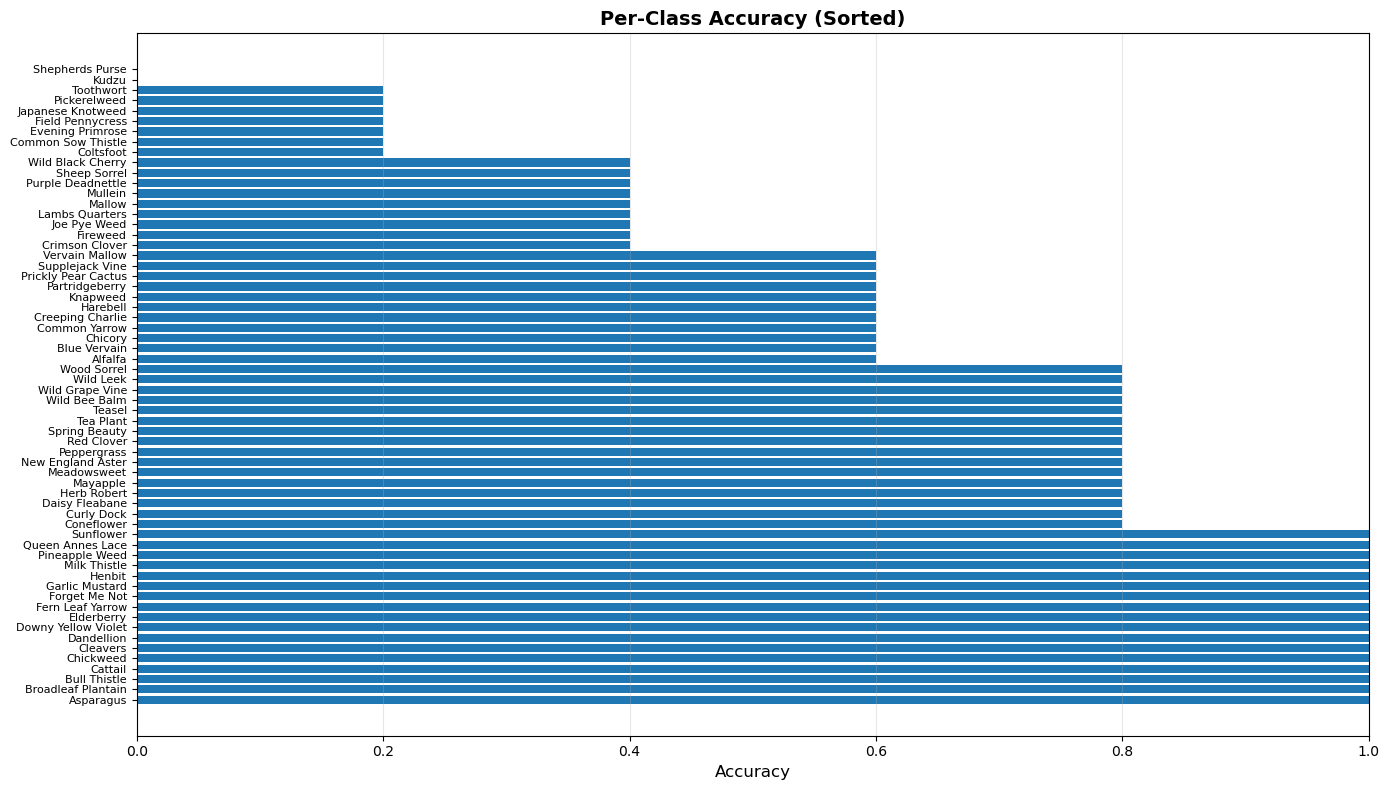

In [17]:
# Sort classes by accuracy
sorted_classes = sorted(
    test_results['per_class_accuracy'].items(),
    key=lambda x: x[1],
    reverse=True
)

print("Top 10 Easiest to Identify:")
print("-" * 40)
for i, (class_name, acc) in enumerate(sorted_classes[:10], 1):
    print(f"{i:2d}. {class_name:30s} {acc:.1%}")

print("\n\nBottom 10 Hardest to Identify:")
print("-" * 40)
for i, (class_name, acc) in enumerate(sorted_classes[-10:], 1):
    print(f"{i:2d}. {class_name:30s} {acc:.1%}")

# Visualize per-class accuracy
plt.figure(figsize=(14, 8))
classes = [x[0] for x in sorted_classes]
accuracies = [x[1] for x in sorted_classes]

plt.barh(range(len(classes)), accuracies)
plt.yticks(range(len(classes)), classes, fontsize=8)
plt.xlabel('Accuracy', fontsize=12)
plt.title('Per-Class Accuracy (Sorted)', fontsize=14, fontweight='bold')
plt.xlim([0, 1])
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


### Confusion Matrix

A confusion matrix shows which species are commonly confused with each other:


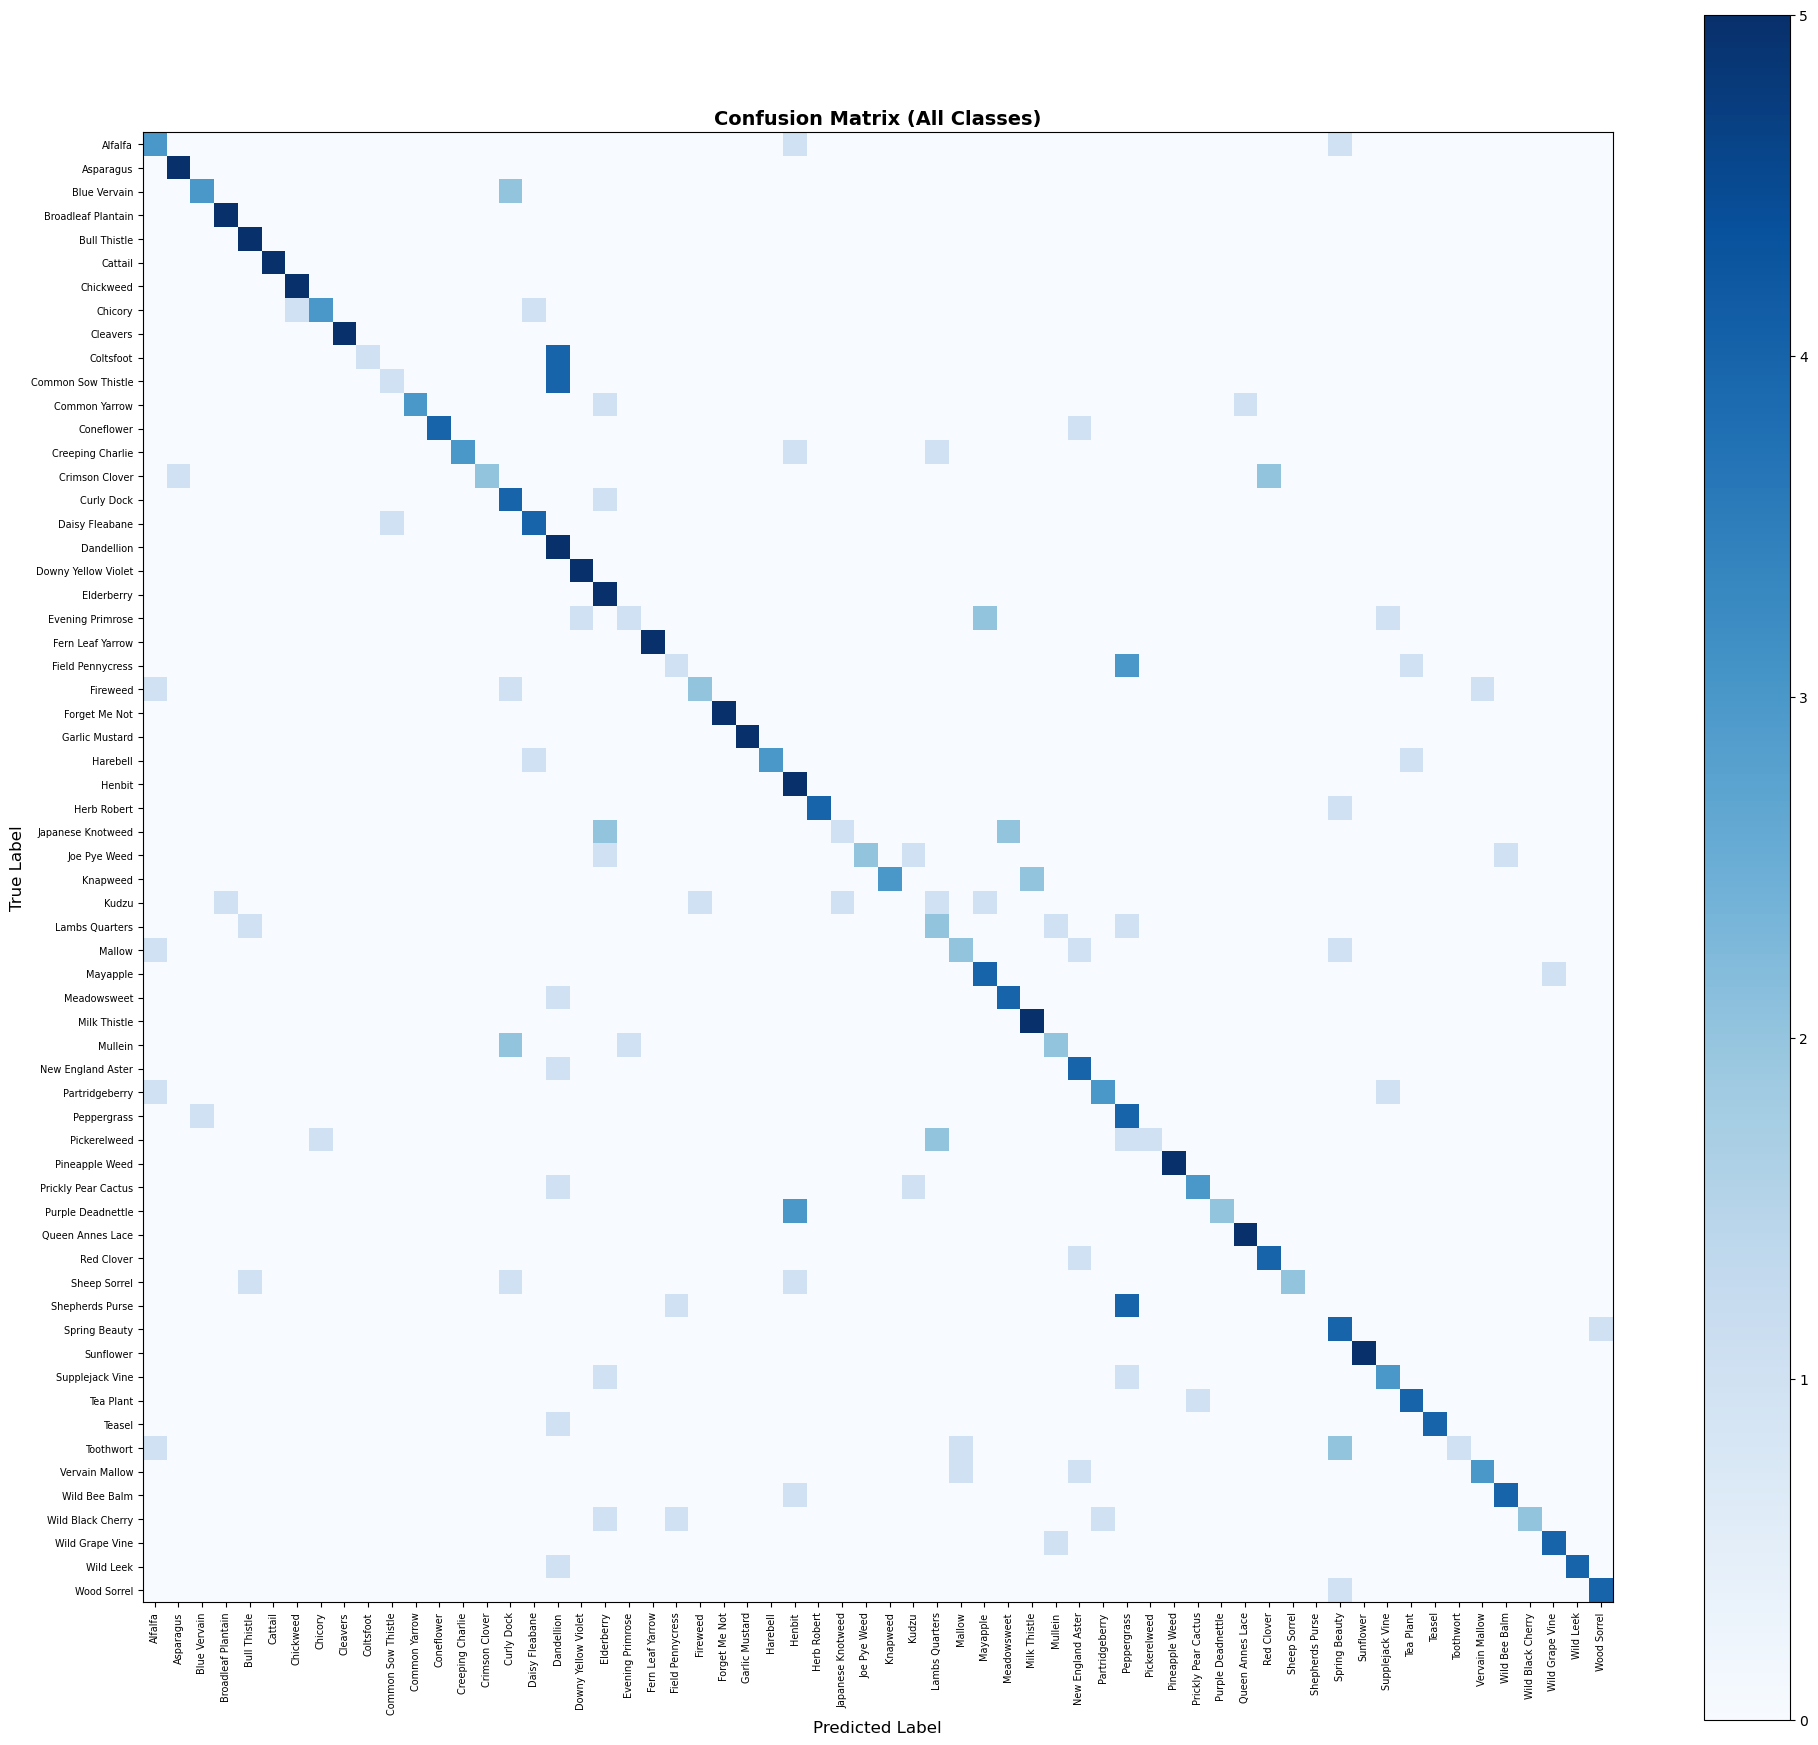


Classification Report:
                     precision    recall  f1-score   support

            Alfalfa       0.43      0.60      0.50         5
          Asparagus       0.83      1.00      0.91         5
       Blue Vervain       0.75      0.60      0.67         5
 Broadleaf Plantain       0.83      1.00      0.91         5
       Bull Thistle       0.71      1.00      0.83         5
            Cattail       1.00      1.00      1.00         5
          Chickweed       0.83      1.00      0.91         5
            Chicory       0.75      0.60      0.67         5
           Cleavers       1.00      1.00      1.00         5
          Coltsfoot       1.00      0.20      0.33         5
 Common Sow Thistle       0.50      0.20      0.29         5
      Common Yarrow       1.00      0.60      0.75         5
         Coneflower       1.00      0.80      0.89         5
   Creeping Charlie       1.00      0.60      0.75         5
     Crimson Clover       1.00      0.40      0.57         5

In [22]:
# Create confusion matrix
cm = confusion_matrix(test_results['true_labels'], test_results['predicted_labels'])

# Plot confusion matrix - show ALL classes
plt.figure(figsize=(20, 18))  # Increased size to accommodate all classes

# Show all classes in the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=90, fontsize=7)
plt.yticks(range(len(class_names)), class_names, fontsize=7)
plt.title('Confusion Matrix (All Classes)', fontsize=14, fontweight='bold')

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print("=" * 60)
print(classification_report(
    test_results['true_labels'],
    test_results['predicted_labels'],
    target_names=class_names,
    zero_division=0
))


### Example Predictions

Let's visualize some example predictions to see how the model performs:


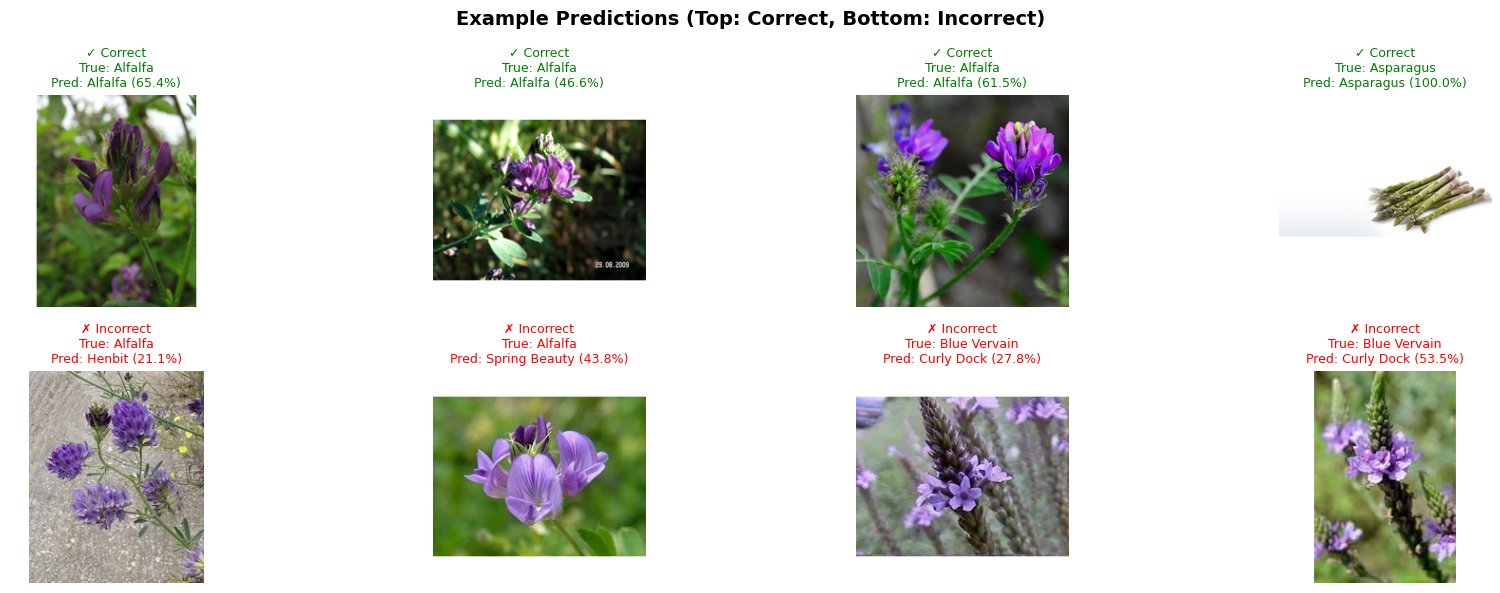

In [19]:
def show_example_predictions(test_results, model, class_names, num_examples=6):
    """
    Display example predictions with visualizations.
    Shows both correct and incorrect predictions.
    """
    # Find some correct and incorrect examples
    correct_examples = []
    incorrect_examples = []
    
    for i, (img_path, true_label, pred_label, prob) in enumerate(
        zip(test_results['test_images'],
            test_results['true_labels'],
            test_results['predicted_labels'],
            test_results['predicted_probs'])
    ):
        if true_label == pred_label and len(correct_examples) < num_examples // 2:
            correct_examples.append((img_path, true_label, pred_label, prob))
        elif true_label != pred_label and len(incorrect_examples) < num_examples // 2:
            incorrect_examples.append((img_path, true_label, pred_label, prob))
        
        if len(correct_examples) >= num_examples // 2 and len(incorrect_examples) >= num_examples // 2:
            break
    
    # Create visualization
    fig, axes = plt.subplots(2, num_examples // 2, figsize=(18, 6))
    if num_examples == 1:
        axes = [[axes]]
    axes = np.array(axes).flatten()
    
    # Show correct predictions
    for i, (img_path, true_label, pred_label, prob) in enumerate(correct_examples):
        img_array = load_and_preprocess_image(img_path, target_size=IMG_SIZE)
        axes[i].imshow(img_array)
        axes[i].set_title(
            f'✓ Correct\nTrue: {class_names[true_label]}\n'
            f'Pred: {class_names[pred_label]} ({prob:.1%})',
            fontsize=9,
            color='green'
        )
        axes[i].axis('off')
    
    # Show incorrect predictions
    for i, (img_path, true_label, pred_label, prob) in enumerate(incorrect_examples):
        img_array = load_and_preprocess_image(img_path, target_size=IMG_SIZE)
        axes[i + num_examples // 2].imshow(img_array)
        axes[i + num_examples // 2].set_title(
            f'✗ Incorrect\nTrue: {class_names[true_label]}\n'
            f'Pred: {class_names[pred_label]} ({prob:.1%})',
            fontsize=9,
            color='red'
        )
        axes[i + num_examples // 2].axis('off')
    
    plt.suptitle('Example Predictions (Top: Correct, Bottom: Incorrect)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Show examples
show_example_predictions(test_results, model, class_names, num_examples=8)


### Detailed Analysis

Let's look at some specific cases where the model made mistakes:


In [20]:
# Find most common misclassifications
misclassifications = defaultdict(lambda: defaultdict(int))

for true_label, pred_label in zip(test_results['true_labels'], test_results['predicted_labels']):
    if true_label != pred_label:
        true_class = class_names[true_label]
        pred_class = class_names[pred_label]
        misclassifications[true_class][pred_class] += 1

# Show top misclassifications
print("Most Common Misclassifications:")
print("=" * 60)
print(f"{'True Species':<30} {'Predicted As':<30} {'Count':<10}")
print("-" * 60)

all_mistakes = []
for true_class, pred_dict in misclassifications.items():
    for pred_class, count in pred_dict.items():
        all_mistakes.append((true_class, pred_class, count))

# Sort by count
all_mistakes.sort(key=lambda x: x[2], reverse=True)

# Show top 15
for true_class, pred_class, count in all_mistakes[:15]:
    print(f"{true_class:<30} {pred_class:<30} {count:<10}")

if len(all_mistakes) == 0:
    print("No misclassifications found! Perfect accuracy!")


Most Common Misclassifications:
True Species                   Predicted As                   Count     
------------------------------------------------------------
Coltsfoot                      Dandellion                     4         
Common Sow Thistle             Dandellion                     4         
Shepherds Purse                Peppergrass                    4         
Field Pennycress               Peppergrass                    3         
Purple Deadnettle              Henbit                         3         
Blue Vervain                   Curly Dock                     2         
Crimson Clover                 Red Clover                     2         
Evening Primrose               Mayapple                       2         
Japanese Knotweed              Elderberry                     2         
Japanese Knotweed              Meadowsweet                    2         
Knapweed                       Milk Thistle                   2         
Mullein                        

## Step 9: Save the Model

Save your trained model so you can use it later without retraining.


In [21]:
# Save the model
model_path = "plant_classifier_improved_model.h5"
model.save(model_path)
print(f"Model saved to {model_path}")

# To load the model later:
# from tensorflow.keras.models import load_model
# model = load_model(model_path)


Model saved to plant_classifier_improved_model.h5
